In [105]:
# Importing PySpark related libraries
from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import concat_ws, regexp_replace, col, lower, to_date, date_format
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, DoubleType
from pyspark.sql.functions import lag, lead, when, coalesce, expr
import pyspark.sql.functions as F
from pyspark.sql.window import Window

# Importing library for Matplotlib
import matplotlib.pyplot as plt

# Importing library for accessing MySQL database
import pymysql

# Importing cProfile and subprocess libraries
import cProfile
import subprocess

# Importing libraries for ADF and KPSS tests
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, LeaveOneOut
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

# Importing libraries for Dash and Plotly for data visualization
import dash
import dash_core_components as dcc
from dash import html
from dash.dependencies import Input, Output
import plotly.graph_objs as go
import plotly.express as px

# Importing additional PySpark functions and features
from pyspark.sql.functions import avg
from pyspark.sql import functions as F

# Importing library for natural language processing with NLTK
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Downloading NLTK datasets if needed
# nltk.download('omw-1.4')
# nltk.download('wordnet')
# nltk.download('vader_lexicon')

# Importing library for datetime operations
from datetime import timedelta, datetime, date

# Importing other libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
spark = SparkSession.builder.appName('ProjectTweets').getOrCreate()

# DATA PREPARATION

In [3]:
df = spark.read.csv('/user1/ProjectTweets.csv', header=True, inferSchema=True)

In [4]:
df.printSchema()

root
 |-- 0: integer (nullable = true)
 |-- 1467810369: long (nullable = true)
 |-- Mon Apr 06 22:19:45 PDT 2009: string (nullable = true)
 |-- NO_QUERY: string (nullable = true)
 |-- _TheSpecialOne_: string (nullable = true)
 |-- @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D: string (nullable = true)



In [5]:
df.show(5, truncate=False)

+---+----------+----------------------------+--------+---------------+-------------------------------------------------------------------------------------------------------------------+
|0  |1467810369|Mon Apr 06 22:19:45 PDT 2009|NO_QUERY|_TheSpecialOne_|@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D|
+---+----------+----------------------------+--------+---------------+-------------------------------------------------------------------------------------------------------------------+
|1  |1467810672|Mon Apr 06 22:19:49 PDT 2009|NO_QUERY|scotthamilton  |is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!    |
|2  |1467810917|Mon Apr 06 22:19:53 PDT 2009|NO_QUERY|mattycus       |@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds                          |
|3  |1467811184|Mon Apr 06 22:19:57 PDT 2009|NO_QUERY|ElleCTF    

In [6]:
new_cols = ['ids', 'date', 'flag', 'user', 'text']

for i, column_name in enumerate(new_cols):
    df = df.withColumnRenamed(df.columns[i + 1], column_name)

In [7]:
spark.conf.set('spark.sql.legacy.timeParserPolicy', 'LEGACY')

In [8]:
date_column = df.select('date')

In [9]:
df = df.withColumn('date', to_date(df['date'], 'EEE MMM dd HH:mm:ss zzz yyyy'))

In [10]:
df = df.withColumn('date', to_date(col('date'), 'dd/MM/yyyy'))

In [11]:
# Convert text data to lowercase and clean unnecessary characters
df = df.withColumn("text", lower(regexp_replace(col("text"), "[^a-zA-Z0-9\\s]", " ")))

In [12]:
# Remove special symbols, and links from text data
df = df.withColumn("text", regexp_replace(col("text"), r'[@#]\w+|https?://\S+|\W', " "))

In [13]:
df.show(1, truncate=False)

+---+----------+----------+--------+-------------+---------------------------------------------------------------------------------------------------------------+
|0  |ids       |date      |flag    |user         |text                                                                                                           |
+---+----------+----------+--------+-------------+---------------------------------------------------------------------------------------------------------------+
|1  |1467810672|2009-04-07|NO_QUERY|scotthamilton|is upset that he can t update his facebook by texting it    and might cry as a result  school today also  blah |
+---+----------+----------+--------+-------------+---------------------------------------------------------------------------------------------------------------+
only showing top 1 row



## Sentiment Analysis without Tokenization, Lemmatization and Removing Stopwords

In [14]:
df_for_sentiment_1 = df.select('date', 'text')

In [15]:
# Create Vader SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Define a function for UDF
def analyze_sentiment(text):
    sentiment = sia.polarity_scores(text)
    return sentiment['compound']

# Save UDF
sentiment_udf = udf(analyze_sentiment, DoubleType())

In [16]:
# Apply Vader analysis and add the results to a new column
df_for_sentiment_1 = df_for_sentiment_1.withColumn("sentiment_score", sentiment_udf(df_for_sentiment_1["text"]))

In [17]:
# Convert "date" column to 'yyyy-MM-dd' format
df_for_sentiment_1 = df_for_sentiment_1.withColumn("date", F.to_date(df_for_sentiment_1["date"]))

In [18]:
# Ensure you're using the correct column name in the aggregation
daily_sentiment_1 = df_for_sentiment_1.groupBy("date").agg(avg("sentiment_score").alias("avg_sentiment_score")).orderBy("date")

In [19]:
# Create a full date array to include the entire date range
min_date = daily_sentiment_1.selectExpr("min(date) as min_date").first().min_date
max_date = daily_sentiment_1.selectExpr("max(date) as max_date").first().max_date

In [20]:
# Create date array
date_range = [min_date + timedelta(days=x) for x in range((max_date - min_date).days + 1)]
date_range_df = spark.createDataFrame([(date,) for date in date_range], ["date"])

In [21]:
# Fill the gap in date column
daily_sentiment_1 = date_range_df.join(daily_sentiment_1, on=["date"], how="left").orderBy("date").fillna(0, subset=["avg_sentiment_score"])

In [22]:
daily_sentiment_1.printSchema()

root
 |-- date: date (nullable = true)
 |-- avg_sentiment_score: double (nullable = false)



In [23]:
daily_sentiment_1.show()

+----------+-------------------+
|      date|avg_sentiment_score|
+----------+-------------------+
|2009-04-07| 0.1638104692791461|
|2009-04-08|                0.0|
|2009-04-09|                0.0|
|2009-04-10|                0.0|
|2009-04-11|                0.0|
|2009-04-12|                0.0|
|2009-04-13|                0.0|
|2009-04-14|                0.0|
|2009-04-15|                0.0|
|2009-04-16|                0.0|
|2009-04-17|                0.0|
|2009-04-18|0.18738602157202913|
|2009-04-19|0.18894100089100915|
|2009-04-20|0.17782408521710552|
|2009-04-21|0.17327567762269075|
|2009-04-22|                0.0|
|2009-04-23|                0.0|
|2009-04-24|                0.0|
|2009-04-25|                0.0|
|2009-04-26|                0.0|
+----------+-------------------+
only showing top 20 rows



In [24]:
# Use the window function to fill the DataFrame with past and future values
window_spec = Window.orderBy("date")

In [25]:
# Fill missing values with 0
daily_sentiment_1 = daily_sentiment_1.fillna(0, subset=['avg_sentiment_score'])

In [26]:
# 1. Apply Backward Fill interpolation
daily_sentiment_1 = daily_sentiment_1.withColumn("backward_fill", lag(daily_sentiment_1["avg_sentiment_score"]).over(window_spec))

In [27]:
# 2. Apply Linear Interpolation
daily_sentiment_1 = daily_sentiment_1.withColumn("linear_fill", lag(daily_sentiment_1["avg_sentiment_score"]).over(window_spec))

In [28]:
# 3. Apply Quadratic Interpolation
daily_sentiment_1 = daily_sentiment_1.withColumn("quadratic_fill", coalesce(
    (lag(daily_sentiment_1["avg_sentiment_score"]).over(window_spec) + 2 * daily_sentiment_1["avg_sentiment_score"] - lead(daily_sentiment_1["avg_sentiment_score"]).over(window_spec)),
    daily_sentiment_1["avg_sentiment_score"]
))

In [29]:
# 4. Apply Mean of Nearest Neighbors interpolation
daily_sentiment_1 = daily_sentiment_1.withColumn("knn_mean", coalesce(
    (daily_sentiment_1["avg_sentiment_score"] + (lag(daily_sentiment_1["avg_sentiment_score"]).over(window_spec) + lead(daily_sentiment_1["avg_sentiment_score"]).over(window_spec)) / 2),
    daily_sentiment_1["avg_sentiment_score"]
))

In [30]:
# 5. Apply Mean of Seasonal Counterparts interpolation
daily_sentiment_1 = daily_sentiment_1.withColumn("seasonal_mean", coalesce(
    (daily_sentiment_1["avg_sentiment_score"] + (lag(daily_sentiment_1["avg_sentiment_score"], 7).over(window_spec) + lead(daily_sentiment_1["avg_sentiment_score"], -7).over(window_spec)) / 2),
    daily_sentiment_1["avg_sentiment_score"]
))

In [31]:
# Collect the results for visualization
interpolated_data = daily_sentiment_1.select("date", "avg_sentiment_score", "backward_fill", "linear_fill", "quadratic_fill", "knn_mean", "seasonal_mean").collect()

2023-11-10 16:10:30,517 WARN window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
2023-11-10 16:10:30,545 WARN window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
2023-11-10 16:10:30,545 WARN window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


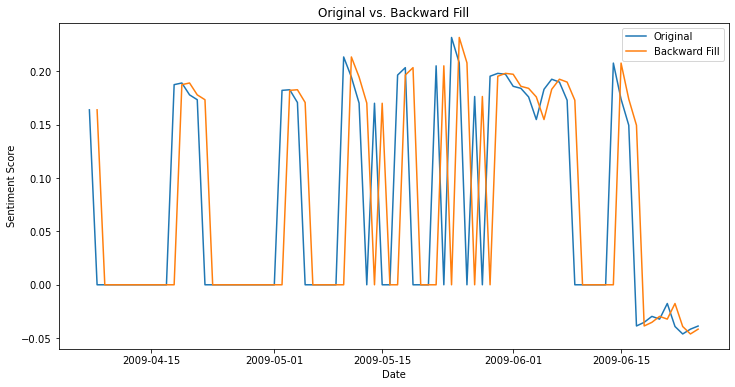

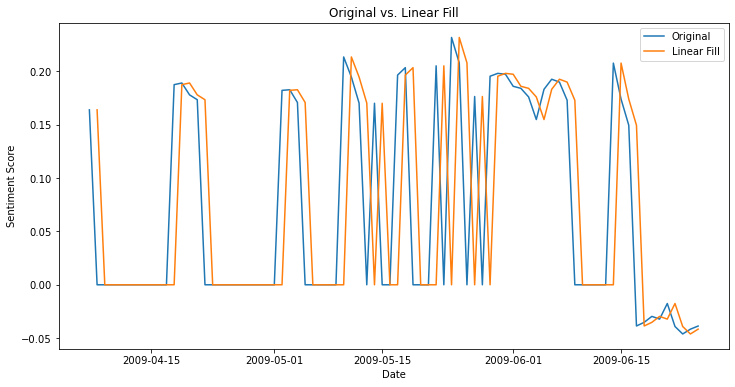

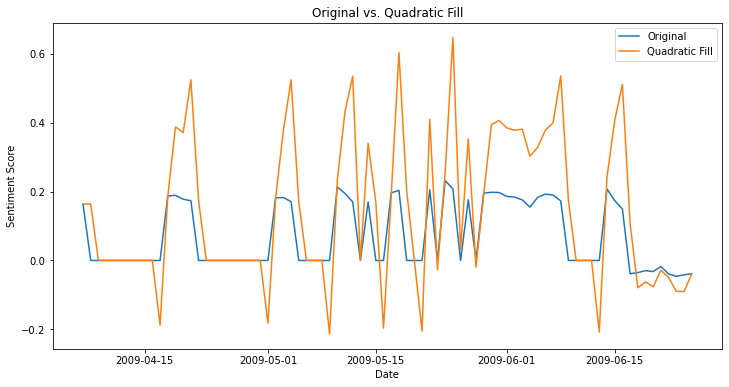

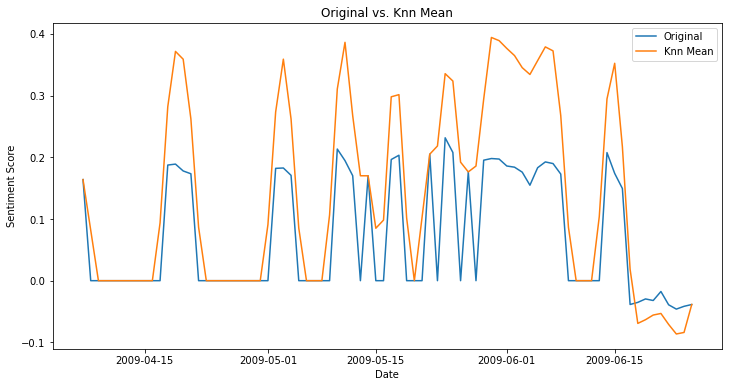

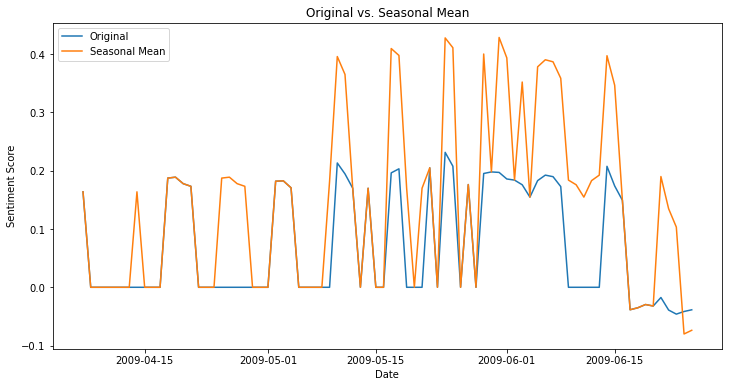

In [32]:
# Extract data for plotting
dates = [row.date for row in interpolated_data]
original_scores = [row.avg_sentiment_score for row in interpolated_data]
interpolation_methods = ["backward_fill", "linear_fill", "quadratic_fill", "knn_mean", "seasonal_mean"]

# Create a loop to plot each interpolation method
for method in interpolation_methods:
    plt.figure(figsize=(12, 6))
    plt.plot(dates, original_scores, label='Original')
    plt.plot(dates, [row[method] for row in interpolated_data], label=method.replace("_", " ").title())  # Use the method name as the label
    plt.xlabel('Date')
    plt.ylabel('Sentiment Score')
    plt.title(f'Original vs. {method.replace("_", " ").title()}')
    plt.legend()
    plt.show()

### Linear Interpolation

In [34]:
# Define a window specification to order the data by date
window_spec = Window.orderBy("date")

# Calculate the next non-null value using the 'last' function
interpolated_df = daily_sentiment_1.withColumn("next_value", F.last("avg_sentiment_score", True).over(window_spec))

# Calculate the previous non-null value using the 'first' function
interpolated_df = interpolated_df.withColumn("prev_value", F.first("avg_sentiment_score", True).over(window_spec))

# Calculate the linearly interpolated value
interpolated_df = interpolated_df.withColumn(
    "interpolated_value",
    F.when(F.col("avg_sentiment_score") == 0, (F.col("next_value") + F.col("prev_value")) / 2).otherwise(F.col("avg_sentiment_score"))
)

# Drop the 'next_value' and 'prev_value' columns if not needed
interpolated_df = interpolated_df.drop("next_value", "prev_value")

In [35]:
interpolated_df.printSchema()

root
 |-- date: date (nullable = true)
 |-- avg_sentiment_score: double (nullable = false)
 |-- backward_fill: double (nullable = true)
 |-- linear_fill: double (nullable = true)
 |-- quadratic_fill: double (nullable = false)
 |-- knn_mean: double (nullable = false)
 |-- seasonal_mean: double (nullable = false)
 |-- interpolated_value: double (nullable = true)



In [36]:
interpolated_df = interpolated_df.select('date', 'interpolated_value')
interpolated_df.show()

2023-11-10 16:30:40,161 WARN window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+----------+-------------------+
|      date| interpolated_value|
+----------+-------------------+
|2009-04-07| 0.1638104692791461|
|2009-04-08|0.08190523463957305|
|2009-04-09|0.08190523463957305|
|2009-04-10|0.08190523463957305|
|2009-04-11|0.08190523463957305|
|2009-04-12|0.08190523463957305|
|2009-04-13|0.08190523463957305|
|2009-04-14|0.08190523463957305|
|2009-04-15|0.08190523463957305|
|2009-04-16|0.08190523463957305|
|2009-04-17|0.08190523463957305|
|2009-04-18|0.18738602157202913|
|2009-04-19|0.18894100089100915|
|2009-04-20|0.17782408521710552|
|2009-04-21|0.17327567762269075|
|2009-04-22|0.08190523463957305|
|2009-04-23|0.08190523463957305|
|2009-04-24|0.08190523463957305|
|2009-04-25|0.08190523463957305|
|2009-04-26|0.08190523463957305|
+----------+-------------------+
only showing top 20 rows



In [37]:
# Get the column names
columns = interpolated_df.columns

# Find and print the count of null values in each column
for column in columns:
    null_count = interpolated_df.filter(interpolated_df[column].isNull()).count()
    print(f"Column '{column}' contains {null_count} null values.")

Column 'date' contains 0 null values.


2023-11-10 16:38:37,480 WARN window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


Column 'interpolated_value' contains 0 null values.


In [38]:
# Start DASH
app = dash.Dash(__name__)

# Configure DASH
app.layout = html.Div([
    dcc.Graph(
        id='line-chart',
        figure=px.line(interpolated_df, x='date', y='interpolated_value', title='Daily Average Sentiment Score')
    )
])

if __name__ == '__main__':
    app.run_server(debug=True,  port=8080)

2023-11-10 16:46:48,068 WARN window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


# Time Series Analysis

In [41]:
# Convert the DF to NumPy array
values = interpolated_df.select("interpolated_value").rdd.flatMap(lambda x: x).collect()

2023-11-10 16:53:03,379 WARN window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [42]:
# ADF(Augmented Dickey Fuller) Test
result_adf = adfuller(values, autolag='AIC')
print(f'ADF Statistic: {result_adf[0]}')
print(f'p-value: {result_adf[1]}')
for key, value in result_adf[4].items():
    print('Critial Values:')
    print(f' {key}, {value}')

# KPSS(Kwiatkowski-Phillips-Schmidt-Shin) Test
result_kpss = kpss(values, regression='c')
print('\nKPSS Statistic: %f' % result_kpss[0])
print('p-value: %f' % result_kpss[1])
for key, value in result_kpss[3].items():
    print('Critial Values:')
    print(f' {key}, {value}')

ADF Statistic: -3.712252757920975
p-value: 0.0039440720931468755
Critial Values:
 1%, -3.5159766913976376
Critial Values:
 5%, -2.898885703483903
Critial Values:
 10%, -2.5866935058484217

KPSS Statistic: 0.282053
p-value: 0.100000
Critial Values:
 10%, 0.347
Critial Values:
 5%, 0.463
Critial Values:
 2.5%, 0.574
Critial Values:
 1%, 0.739


/home/hduser/.local/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




The ADF test is commonly used to check if a time series has a unit root, indicating non-stationarity. If the p-value in the ADF test is below 0.05, you reject the null hypothesis.

The KPSS test is commonly used to check if a time series has a unit root, indicating non-stationarity. If the p-value in the ADF test is below 0.05, you conclude that the time series is non-stationary.

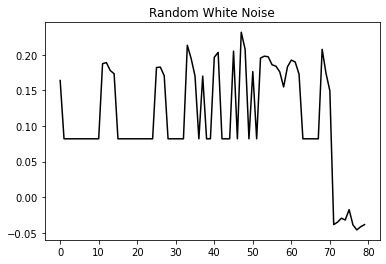

In [43]:
# Take the DF from pyspark
plt.plot(values, color='k')
plt.title('Random White Noise')
plt.show()

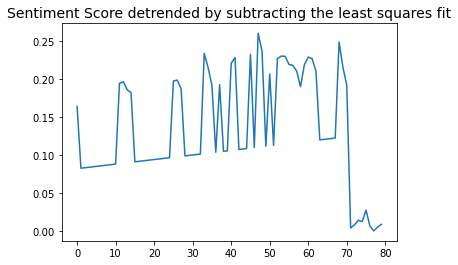

In [44]:
# Detrend the DF
detrended = np.array(values) - np.polyfit(range(len(values)), values, 1)[0] * np.arange(len(values))

# Visualize the detrended DF
plt.plot(detrended)
plt.title('Sentiment Score detrended by subtracting the least squares fit', fontsize=14)
plt.show()

# Seasonality

In [45]:
interpolated_df_pd= interpolated_df.toPandas()

In [46]:
interpolated_df_pd.head()

,date,interpolated_value
0,2009-04-07,0.163810
1,2009-04-08,0.081905
2,2009-04-09,0.081905
3,2009-04-10,0.081905
4,2009-04-11,0.081905


In [47]:
# Preparation for the Algorithm
# ==============================================================================
interpolated_df_pd['date'] = pd.to_datetime(interpolated_df_pd['date'], format='%Y/%m/%d')
interpolated_df_pd = interpolated_df_pd.set_index('date')
interpolated_df_pd = interpolated_df_pd.asfreq('D')
interpolated_df_pd = interpolated_df_pd.sort_index()
interpolated_df_pd.head()

,interpolated_value
date,
2009-04-07,0.163810
2009-04-08,0.081905
2009-04-09,0.081905
2009-04-10,0.081905
2009-04-11,0.081905


In [48]:
print(f'Number of rows with missing values: {interpolated_df_pd.isnull().any(axis=1).mean()}')

Number of rows with missing values: 0.0


In [49]:
# Verify that a temporary index is complete
# ==============================================================================
(interpolated_df_pd.index == pd.date_range(start=interpolated_df_pd.index.min(),
end=interpolated_df_pd.index.max(),
freq=interpolated_df_pd.index.freq)).all()

True

## AutoRegressive

In [50]:
# Split data into train-test
# ==============================================================================

# Define the number of steps for test data
steps = 20

# Split the data into training and test sets
data_train = interpolated_df_pd[:-steps]
data_test = interpolated_df_pd[-steps:]

Train dates : 2009-04-07 00:00:00 --- 2009-06-05 00:00:00 (n=60)
Test dates : 2009-06-06 00:00:00 --- 2009-06-25 00:00:00 (n=20


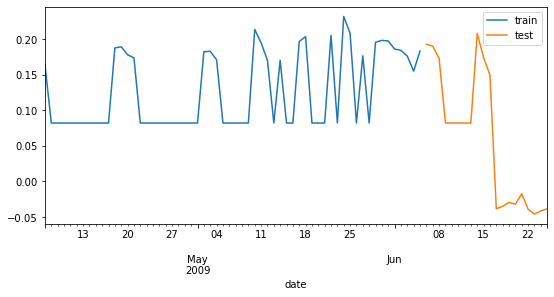

In [51]:
# Print information about the split
print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()} (n={len(data_train)})")
print(f"Test dates : {data_test.index.min()} --- {data_test.index.max()} (n={len(data_test)}")

# Create a plot to visualize the train and test data
fig, ax = plt.subplots(figsize=(9, 4))
data_train['interpolated_value'].plot(ax=ax, label='train')
data_test['interpolated_value'].plot(ax=ax, label='test')
ax.legend();

In [52]:
# Define your lag variables
# ==============================================================================
data_train['lag1'] = data_train['interpolated_value'].shift(1)
data_train['lag2'] = data_train['interpolated_value'].shift(2)

# Drop missing values
data_train = data_train.dropna()

In [53]:
# Create and train AR model
# ==============================================================================
X = data_train[['lag1', 'lag2']]
X = sm.add_constant(X)  # Add a constant for the intercept
y = data_train['interpolated_value']

model = sm.OLS(y, X).fit()

# Print model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     interpolated_value   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     4.775
Date:                Fri, 10 Nov 2023   Prob (F-statistic):             0.0122
Time:                        16:58:30   Log-Likelihood:                 91.954
No. Observations:                  58   AIC:                            -177.9
Df Residuals:                      55   BIC:                            -171.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0731      0.020      3.610      0.0

In [55]:
# Initialize lag values
lag1 = data_train['lag1'].iloc[-1]  
lag2 = data_train['lag2'].iloc[-1]  


# Predict 'steps' time periods into the future
forecasted_values = []

for _ in range(steps):
    # Calculate the prediction
    y_pred = model.predict([1, lag1, lag2])
    forecasted_values.append(y_pred[0])  # Access the first element directly

    # Update lag values for the next prediction
    lag2 = lag1
    lag1 = y_pred[0]  # Access the first element directly

In [56]:
# Create a DataFrame for the predictions with date index
prediction_dates = data_test.index[-steps:]
predictions = pd.DataFrame({'Predicted': forecasted_values}, index=prediction_dates)

In [57]:
# Print the first 5 rows of the DataFrames
predictions.head()

,Predicted
date,
2009-06-06,0.142047
2009-06-07,0.135797
2009-06-08,0.132519
2009-06-09,0.130834
2009-06-10,0.129962


In [58]:
data_train.head()

,interpolated_value,lag1,lag2
date,,,
2009-04-09,0.081905,0.081905,0.163810
2009-04-10,0.081905,0.081905,0.081905
2009-04-11,0.081905,0.081905,0.081905
2009-04-12,0.081905,0.081905,0.081905
2009-04-13,0.081905,0.081905,0.081905


In [59]:
data_test.head()

,interpolated_value
date,
2009-06-06,0.192470
2009-06-07,0.189789
2009-06-08,0.172798
2009-06-09,0.081905
2009-06-10,0.081905


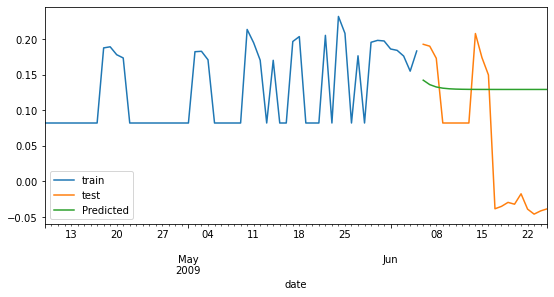

In [60]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train['interpolated_value'].plot(ax=ax, label='train')
data_test['interpolated_value'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [61]:
# Calculate the test error (MSE)
error_mse = mean_squared_error(
    y_true=data_test['interpolated_value'],
    y_pred=predictions['Predicted']
)

# Print the test error
print(f"Test error (MSE): {error_mse}")

Test error (MSE): 0.013544959047254643


In [62]:
# Define the hyperparameter grid
param_grid = {
    'n_estimators': [1, 500],
    'max_depth': [1, 2, 3, 4 ,5]
}

# Create the RandomForestRegressor
regressor = RandomForestRegressor(random_state=42)

# Create Leave-One-Out Cross-Validation
loo = LeaveOneOut()

# Initialize variables to store the best hyperparameters and MSE
best_params = None
best_mse = float('inf')

# Perform LOOCV to search for the best hyperparameters
for train_index, test_index in loo.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Create GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, scoring='neg_mean_squared_error', cv=2)
    grid_search.fit(X_train, y_train)

    # Get the best hyperparameters and the best model
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_

    # Evaluate the best model on the test data
    forecasted_values = best_model.predict(X_test)

    # Calculate the mean squared error
    mse = mean_squared_error(y_test, forecasted_values)

    if mse < best_mse:
        best_mse = mse

# Print the results
print("Best Hyperparameters:")
print("n_estimators:", best_params['n_estimators'])
print("max_depth:", best_params['max_depth'])
print(f"Best MSE: {best_mse}")

Best Hyperparameters:
n_estimators: 500
max_depth: 3
Best MSE: 7.873256180015573e-08


In [64]:
# Define the hyperparameters
n_estimators = 500
max_depth = 3

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


# Create and train a RandomForestRegressor with the best hyperparameters
regressor = RandomForestRegressor(max_depth=max_depth, n_estimators=n_estimators, random_state=42)
regressor.fit(X, y)

RandomForestRegressor(max_depth=3, n_estimators=500, random_state=42)

In [65]:
# Predictions on the test set
forecasted_values = regressor.predict(X_test)

In [66]:
print(forecasted_values)

[0.10243441 0.10474582 0.10939409 0.11174177 0.13556421 0.1816439
 0.10522063 0.17495497 0.18132699 0.15978955 0.17628561 0.10474582
 0.09781702 0.10474582 0.10474582 0.10474582 0.10474582 0.10474582
 0.14135681 0.10474582]


In [67]:
# Create an index for the forecasted values
forecasted_index = data_test.index[:len(forecasted_values)]

In [68]:
print(forecasted_index)

DatetimeIndex(['2009-06-06', '2009-06-07', '2009-06-08', '2009-06-09',
               '2009-06-10', '2009-06-11', '2009-06-12', '2009-06-13',
               '2009-06-14', '2009-06-15', '2009-06-16', '2009-06-17',
               '2009-06-18', '2009-06-19', '2009-06-20', '2009-06-21',
               '2009-06-22', '2009-06-23', '2009-06-24', '2009-06-25'],
              dtype='datetime64[ns]', name='date', freq='D')


In [72]:
# Convert prediction values and index to a DataFrame
forecasted_data = pd.DataFrame({'Predicted': forecasted_values}, index=forecasted_index)

# Results
forecasted_data.tail()

,Predicted
date,
2009-06-06,0.102434
2009-06-07,0.104746
2009-06-08,0.109394
2009-06-09,0.111742
2009-06-10,0.135564


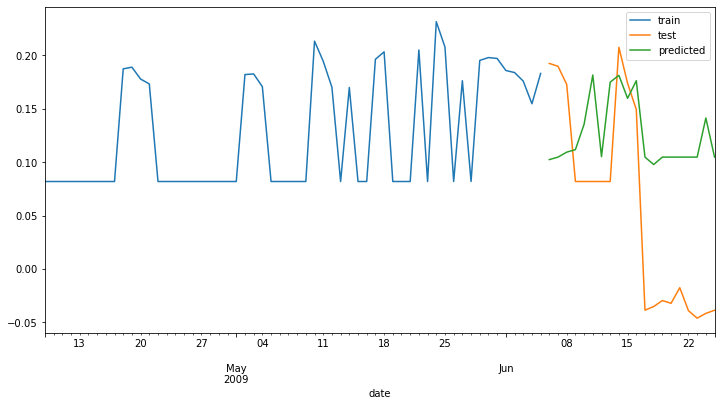

In [74]:
# Plot
fig, ax = plt.subplots(figsize=(12, 6))
data_train['interpolated_value'].plot(ax=ax, label='train')
data_test['interpolated_value'].plot(ax=ax, label='test')
forecasted_data['Predicted'].plot(ax=ax, label='predicted')
ax.legend()
plt.show()

In [75]:
# Calculate the Mean Squared Error
mse = mean_squared_error(y_test, forecasted_values)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.0012928597524841322


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10
 This problem is unconstrained.

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.28589D-01    |proj g|=  4.53985D+01

At iterate    5    f= -1.41320D+00    |proj g|=  2.33389D-01

At iterate   10    f= -1.47099D+00    |proj g|=  6.51840D-01

At iterate   15    f= -1.53016D+00    |proj g|=  1.50109D-02

At iterate   20    f= -1.53422D+00    |proj g|=  8.28062D-01

At iterate   25    f= -1.54880D+00    |proj g|=  1.66649D-01

At iterate   30    f= -1.54948D+00    |proj g|=  3.06920D-01

At iterate   35    f= -1.55448D+00    |proj g|=  2.71718D-01

At iterate   40    f= -1.55508D+00    |proj g|=  4.96133D-02

At iterate   45    f= -1.55518D+00    |proj g|=  1.65602D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of

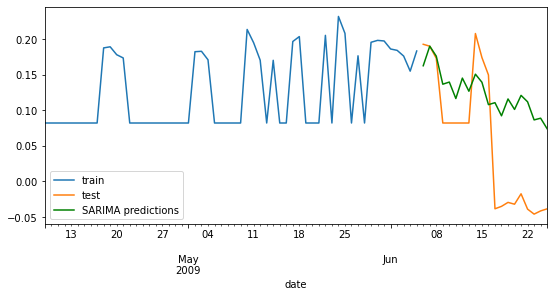

SARIMA Test error (MSE): 0.009333631826786511


In [77]:
# Fit a SARIMA model
order = (2, 0, 0)  # Non-seasonal order
seasonal_order = (1, 0, 1, 7)  # Seasonal order (p, d, q, S)

model_sarima = SARIMAX(data_train['interpolated_value'], order=order, seasonal_order=seasonal_order)
results_sarima = model_sarima.fit()

# Make predictions on the test set
forecasted_values_sarima = results_sarima.predict(start=len(data_train), end=len(data_train) + len(data_test) - 1, typ='levels')

# Create an index for the forecasted values
forecasted_index_sarima = data_test.index[:len(forecasted_values_sarima)]

# Plot
fig, ax = plt.subplots(figsize=(9, 4))
data_train['interpolated_value'].plot(ax=ax, label='train')
data_test['interpolated_value'].plot(ax=ax, label='test')
forecasted_values_sarima.plot(ax=ax, label='SARIMA predictions', color='green')
ax.legend()
plt.show()

# Calculate the test error (MSE)
error_mse_sarima = mean_squared_error(
    y_true=data_test['interpolated_value'],
    y_pred=forecasted_values_sarima
)

# Print the test error for SARIMA
print(f"SARIMA Test error (MSE): {error_mse_sarima}")

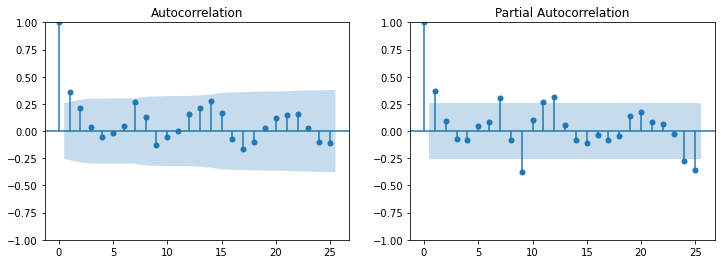

In [78]:
# Create lag variables
data_train['lag1'] = data_train['interpolated_value'].shift(1)
data_train['lag2'] = data_train['interpolated_value'].shift(2)
# Plot ACF and PACF
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(data_train['interpolated_value'], lags=25, ax=ax[0])
plot_pacf(data_train['interpolated_value'], lags=25, ax=ax[1])
plt.show()

# Lemmatization, Tokenization, StopWordsRemover

In [79]:
# Lemmatization using NLTK
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    words = text.split()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

lemmatize_udf = udf(lemmatize_text, StringType())
df = df.withColumn("text", lemmatize_udf("text"))

In [80]:
# Tokenization
tokenizer = Tokenizer(inputCol="text", outputCol="filtered_words")
df = tokenizer.transform(df)

In [81]:
# Use StopWordsRemover on the "filtered_words" column in your example DataFrame
remover = StopWordsRemover(inputCol="filtered_words", outputCol="filtered_words_without_stopwords")
df = remover.transform(df)

# You can update the column name as per your needs
df = df.withColumnRenamed("filtered_words_without_stopwords", "filtered_words_final")

# Preparing the Dataset for the Databases

In [82]:
# Just pick the necessary columns
df = df.select('0', 'ids', 'date', 'flag', 'user', 'filtered_words_final')

# Rename the "0" column to "index"
df = df.withColumnRenamed("0", "tweet_index")

# Show the result
#df.show(truncate=False)

In [83]:
df.dropna()

DataFrame[tweet_index: int, ids: bigint, date: date, flag: string, user: string, filtered_words_final: array<string>]

In [ ]:
# Count the total number of values in the dataframe
total_count = df.count()

# Show the total count
print("Total count of values in the dataframe", total_count)

# MySQL

In [85]:
# Connect to the database
connection = pymysql.connect(
    host="localhost",
    user="root",
    password="password",
    database="ProjectTweets",
    charset='utf8mb4',
    cursorclass=pymysql.cursors.DictCursor
)

In [88]:
# Create a cursor
cursor = connection.cursor()

# Create a table
create_table_sql = """
CREATE TABLE IF NOT EXISTS Tweets (
    tweet_index INT AUTO_INCREMENT PRIMARY KEY,
    ids BIGINT,
    date DATE,
    flag VARCHAR(55),
    user VARCHAR(255),
    filtered_words_final TEXT
);
"""

In [89]:
# Create a table
cursor.execute(create_table_sql)

# Save changes
connection.commit()

In [90]:
# Combine the column named 'filtered_words_final' into a comma-separated column of text.
df = df.withColumn('concatenated_words', concat_ws(",", df['filtered_words_final']))
df.printSchema()

root
 |-- tweet_index: integer (nullable = true)
 |-- ids: long (nullable = true)
 |-- date: date (nullable = true)
 |-- flag: string (nullable = true)
 |-- user: string (nullable = true)
 |-- filtered_words_final: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- concatenated_words: string (nullable = false)



In [91]:
df = df.select('tweet_index', 'ids', 'date', 'flag', 'user', 'concatenated_words')
df.show(1, truncate=False)

+-----------+----------+----------+--------+-------------+---------------------------------------------------------------------+
|tweet_index|ids       |date      |flag    |user         |concatenated_words                                                   |
+-----------+----------+----------+--------+-------------+---------------------------------------------------------------------+
|1          |1467810672|2009-04-07|NO_QUERY|scotthamilton|upset,update,facebook,texting,might,cry,result,school,today,also,blah|
+-----------+----------+----------+--------+-------------+---------------------------------------------------------------------+
only showing top 1 row



In [92]:
df.printSchema()

root
 |-- tweet_index: integer (nullable = true)
 |-- ids: long (nullable = true)
 |-- date: date (nullable = true)
 |-- flag: string (nullable = true)
 |-- user: string (nullable = true)
 |-- concatenated_words: string (nullable = false)



In [93]:
mysql_url = "jdbc:mysql://localhost:3306/ProjectTweets"
mysql_properties = {
    "user": "root",
    "password": "password",
}

In [94]:
df.write.jdbc(url=mysql_url, table="Tweets", mode="overwrite", properties=mysql_properties)

In [96]:
# Execute the ALTER TABLE query
#alter_table_sql = "ALTER TABLE Tweets ADD COLUMN IF NOT EXISTS YCSB_KEY VARCHAR(255);"
#cursor.execute(alter_table_sql)

In [97]:
connection.commit()

In [98]:
df_from_mysql = spark.read.jdbc(url=mysql_url, table="Tweets", properties=mysql_properties)

### Showing results from MySQL

In [99]:
# Checking the database after insertin the dataframe
df_from_mysql.show()

+-----------+----------+----------+--------+---------------+--------------------+
|tweet_index|       ids|      date|    flag|           user|  concatenated_words|
+-----------+----------+----------+--------+---------------+--------------------+
|          1|1467810672|2009-04-07|NO_QUERY|  scotthamilton|upset,update,face...|
|          2|1467810917|2009-04-07|NO_QUERY|       mattycus|kenichan,dived,ma...|
|          3|1467811184|2009-04-07|NO_QUERY|        ElleCTF|whole,body,feel,i...|
|          4|1467811193|2009-04-07|NO_QUERY|         Karoli|nationwideclass,b...|
|          5|1467811372|2009-04-07|NO_QUERY|       joy_wolf| kwesidei,whole,crew|
|          6|1467811592|2009-04-07|NO_QUERY|        mybirch|            need,hug|
|          7|1467811594|2009-04-07|NO_QUERY|           coZZ|loltrish,hey,long...|
|          8|1467811795|2009-04-07|NO_QUERY|2Hood4Hollywood| tatiana,k,nope,didn|
|          9|1467812025|2009-04-07|NO_QUERY|        mimismo|  twittera,que,muera|
|         10|146

- Create an extra table to determine the problem in YCSB

In [100]:
# Create a cursor
cursor = connection.cursor()

# Create a table
create_table_sql = """
CREATE TABLE IF NOT EXISTS YCSB_TEST (
    tweet_index INT AUTO_INCREMENT PRIMARY KEY,
    ids BIGINT,
    date DATE,
    flag VARCHAR(55),
    user VARCHAR(255),
    filtered_words_final TEXT,
    YCSB_KEY VARCHAR(255)
);
"""

In [101]:
#Create a table
cursor.execute(create_table_sql)

#Save changes
connection.commit()

In [106]:
command = "/home/hduser/ycsb-0.17.0/bin/ycsb.sh load jdbc -P /home/hduser/ycsb-0.17.0/jdbc-binding/conf/db.properties -P /home/hduser/ycsb-0.17.0/workloads/workloada -p db.connection_properties=\"user=root&password=password&useSSL=false\" -p jdbc.url=jdbc:mysql://localhost:3306/ProjectTweets -p table=YCSB_TEST"

process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
stdout, stderr = process.communicate()

if process.returncode == 0:
    print("YCSB operation completed successfully.")
    print("Output:")
    print(stdout.decode('utf-8'))
else:
    print("YCSB operation failed. Error message:")
    print(stderr.decode('utf-8'))

YCSB operation completed successfully.
Output:
/usr/bin/java  -classpath /home/hduser/ycsb-0.17.0/conf:/home/hduser/ycsb-0.17.0/lib/HdrHistogram-2.1.4.jar:/home/hduser/ycsb-0.17.0/lib/core-0.17.0.jar:/home/hduser/ycsb-0.17.0/lib/htrace-core4-4.1.0-incubating.jar:/home/hduser/ycsb-0.17.0/lib/jackson-core-asl-1.9.4.jar:/home/hduser/ycsb-0.17.0/lib/jackson-mapper-asl-1.9.4.jar:/home/hduser/ycsb-0.17.0/jdbc-binding/conf:/home/hduser/ycsb-0.17.0/jdbc-binding/lib/commons-collections-3.2.1.jar:/home/hduser/ycsb-0.17.0/jdbc-binding/lib/commons-lang-2.4.jar:/home/hduser/ycsb-0.17.0/jdbc-binding/lib/commons-pool-1.5.4.jar:/home/hduser/ycsb-0.17.0/jdbc-binding/lib/geronimo-jms_1.1_spec-1.1.1.jar:/home/hduser/ycsb-0.17.0/jdbc-binding/lib/geronimo-jta_1.1_spec-1.1.1.jar:/home/hduser/ycsb-0.17.0/jdbc-binding/lib/jdbc-binding-0.17.0.jar:/home/hduser/ycsb-0.17.0/jdbc-binding/lib/mysql-connector-j-8.0.33.jar:/home/hduser/ycsb-0.17.0/jdbc-binding/lib/mysql-connector-java-8.0.30.jar:/home/hduser/ycsb-0.1

### Due to unidentified Issue YCSB did not work. I decided to use cProfile.

In [107]:
# Example query
query = "SELECT * FROM Tweets WHERE concatenated_words"

In [108]:
def perform_query():
    cursor = connection.cursor()
    cursor.execute(query)
    results = cursor.fetchall()
    cursor.close()

if __name__ == '__main__':
    cProfile.run("perform_query()", sort="cumulative")

         1063494 function calls in 2.390 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    2.390    2.390 {built-in method builtins.exec}
        1    0.020    0.020    2.390    2.390 <string>:1(<module>)
        1    0.000    0.000    2.370    2.370 2091401167.py:1(perform_query)
        1    0.000    0.000    2.370    2.370 cursors.py:133(execute)
        1    0.000    0.000    2.370    2.370 cursors.py:319(_query)
        1    0.000    0.000    2.343    2.343 connections.py:552(query)
        1    0.000    0.000    2.334    2.334 connections.py:810(_read_query_result)
        1    0.000    0.000    2.334    2.334 connections.py:1198(read)
        1    0.000    0.000    2.321    2.321 connections.py:1281(_read_result_packet)
        1    0.017    0.017    2.321    2.321 connections.py:1327(_read_rowdata_packet)
    16866    0.075    0.000    1.971    0.000 connections.py:730(_read_packet)
  

    Total calls: 1,131,181
    Total time: 3.526 seconds

Top time-consuming functions:

    {built-in method builtins.exec}: 3.526 seconds
    <string>:1(<module>): 3.526 seconds
    3302925674.py:3(perform_query): 3.524 seconds
    cursors.py:133(execute): 3.524 seconds
    cursors.py:319(_query): 3.524 seconds

# Hive

In [109]:
df.createOrReplaceTempView("temp_table")

In [110]:
spark.sql("CREATE DATABASE IF NOT EXISTS ProjectTweets")

2023-11-10 17:24:07,344 WARN metastore.ObjectStore: Failed to get database global_temp, returning NoSuchObjectException
2023-11-10 17:24:07,392 ERROR metastore.RetryingHMSHandler: AlreadyExistsException(message:Database projecttweets already exists)
	at org.apache.hadoop.hive.metastore.HiveMetaStore$HMSHandler.create_database(HiveMetaStore.java:925)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at org.apache.hadoop.hive.metastore.RetryingHMSHandler.invokeInternal(RetryingHMSHandler.java:148)
	at org.apache.hadoop.hive.metastore.RetryingHMSHandler.invoke(RetryingHMSHandler.java:107)
	at com.sun.proxy.$Proxy34.create_database(Unknown Source)
	at org.apache.hadoop.hive.metastore.HiveMetaStoreClient.createDatabase(HiveMetaStoreClient.java:727)
	at su

DataFrame[]

In [111]:
create_table_sql = """
CREATE TABLE IF NOT EXISTS ProjectTweets.Tweets (
    tweet_index INT,
    ids BIGINT,
    date DATE,
    flag STRING,
    user STRING,
    concatenated_words STRING
)
STORED AS PARQUET
"""
spark.sql(create_table_sql)

2023-11-10 17:24:07,877 WARN session.SessionState: METASTORE_FILTER_HOOK will be ignored, since hive.security.authorization.manager is set to instance of HiveAuthorizerFactory.
2023-11-10 17:24:08,068 WARN conf.HiveConf: HiveConf of name hive.internal.ss.authz.settings.applied.marker does not exist
2023-11-10 17:24:08,085 WARN conf.HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
2023-11-10 17:24:08,094 WARN conf.HiveConf: HiveConf of name hive.stats.retries.wait does not exist
2023-11-10 17:24:08,175 ERROR metastore.RetryingHMSHandler: AlreadyExistsException(message:Table tweets already exists)
	at org.apache.hadoop.hive.metastore.HiveMetaStore$HMSHandler.create_table_core(HiveMetaStore.java:1416)
	at org.apache.hadoop.hive.metastore.HiveMetaStore$HMSHandler.create_table_with_environment_context(HiveMetaStore.java:1503)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at 

DataFrame[]

In [112]:
hive_insert_data_sql = """
INSERT INTO ProjectTweets SELECT * FROM temp_table
"""

In [113]:
spark.sql(hive_insert_data_sql)

DataFrame[]

### Showing results from Hive

In [114]:
# Query
result = spark.sql("SELECT * FROM ProjectTweets")

# Show Result
result.show()

+-----------+----------+----------+--------+---------------+--------------------+
|tweet_index|       ids|      date|    flag|           user|filtered_words_final|
+-----------+----------+----------+--------+---------------+--------------------+
|          1|1467810672|2009-04-07|NO_QUERY|  scotthamilton|upset,update,face...|
|          2|1467810917|2009-04-07|NO_QUERY|       mattycus|,kenichan,dived,m...|
|          3|1467811184|2009-04-07|NO_QUERY|        ElleCTF|whole,body,feels,...|
|          4|1467811193|2009-04-07|NO_QUERY|         Karoli|,nationwideclass,...|
|          5|1467811372|2009-04-07|NO_QUERY|       joy_wolf|,kwesidei,whole,crew|
|          6|1467811592|2009-04-07|NO_QUERY|        mybirch|            need,hug|
|          7|1467811594|2009-04-07|NO_QUERY|           coZZ|,loltrish,hey,,lo...|
|          8|1467811795|2009-04-07|NO_QUERY|2Hood4Hollywood|,tatiana,k,nope,didn|
|          9|1467812025|2009-04-07|NO_QUERY|        mimismo| ,twittera,que,muera|
|         10|146

In [115]:
command = "/home/hduser/ycsb-0.17.0/bin/ycsb.sh load jdbc -P /home/hduser/ycsb-0.17.0/jdbc-binding/conf/db.properties -P /home/hduser/ycsb-0.17.0/workloads/workloada -p db.connection_properties=\"user=root&password=password\" -p jdbc.url=jdbc:hive2://hive_server:10000/ProjectTweets"

process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
stdout, stderr = process.communicate()

if process.returncode == 0:
    print("YCSB operation completed successfully.")
    print("Output:")
    print(stdout.decode('utf-8'))
else:
    print("YCSB operation failed. Error message:")
    print(stderr.decode('utf-8'))

YCSB operation completed successfully.
Output:
/usr/bin/java  -classpath /home/hduser/ycsb-0.17.0/conf:/home/hduser/ycsb-0.17.0/lib/HdrHistogram-2.1.4.jar:/home/hduser/ycsb-0.17.0/lib/core-0.17.0.jar:/home/hduser/ycsb-0.17.0/lib/htrace-core4-4.1.0-incubating.jar:/home/hduser/ycsb-0.17.0/lib/jackson-core-asl-1.9.4.jar:/home/hduser/ycsb-0.17.0/lib/jackson-mapper-asl-1.9.4.jar:/home/hduser/ycsb-0.17.0/jdbc-binding/conf:/home/hduser/ycsb-0.17.0/jdbc-binding/lib/commons-collections-3.2.1.jar:/home/hduser/ycsb-0.17.0/jdbc-binding/lib/commons-lang-2.4.jar:/home/hduser/ycsb-0.17.0/jdbc-binding/lib/commons-pool-1.5.4.jar:/home/hduser/ycsb-0.17.0/jdbc-binding/lib/geronimo-jms_1.1_spec-1.1.1.jar:/home/hduser/ycsb-0.17.0/jdbc-binding/lib/geronimo-jta_1.1_spec-1.1.1.jar:/home/hduser/ycsb-0.17.0/jdbc-binding/lib/jdbc-binding-0.17.0.jar:/home/hduser/ycsb-0.17.0/jdbc-binding/lib/mysql-connector-j-8.0.33.jar:/home/hduser/ycsb-0.17.0/jdbc-binding/lib/mysql-connector-java-8.0.30.jar:/home/hduser/ycsb-0.1

In [117]:
import cProfile
import pstats

In [118]:
# my_hive_script.py
def hive_query():
    query
    pass

if __name__ == "__main__":
    cProfile.run("hive_query()", sort="cumulative")
    
    # Show the results with pstat
    p = pstats.Stats()
    p.print_stats()

         4 function calls in 0.000 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 99812281.py:2(hive_query)
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}


         0 function calls in 0.000 seconds



# SENTIMENT ANALYSIS AFTER TOKENIZATION, LEMMATIZATION AND STOPWORDS REMOVAL

In [119]:
df_for_sentiment_2 = df.select('date', 'concatenated_words')

In [120]:
# Create Vader SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Define a function for the UDF
def analyze_sentiment(text):
    sentiment = sia.polarity_scores(text)
    return sentiment['compound']

# Save UDF
sentiment_udf = udf(analyze_sentiment, DoubleType())

In [121]:
# Apply Vader analysis and add the results to a new column
df_for_sentiment_2 = df_for_sentiment_2.withColumn("sentiment_score", sentiment_udf(df_for_sentiment_2["concatenated_words"]))

df_for_sentiment_2.show()

+----------+--------------------+---------------+
|      date|  concatenated_words|sentiment_score|
+----------+--------------------+---------------+
|2009-04-07|upset,update,face...|            0.0|
|2009-04-07|kenichan,dived,ma...|            0.0|
|2009-04-07|whole,body,feel,i...|            0.0|
|2009-04-07|nationwideclass,b...|            0.0|
|2009-04-07| kwesidei,whole,crew|            0.0|
|2009-04-07|            need,hug|            0.0|
|2009-04-07|loltrish,hey,long...|            0.0|
|2009-04-07| tatiana,k,nope,didn|            0.0|
|2009-04-07|  twittera,que,muera|            0.0|
|2009-04-07|spring,break,plai...|            0.0|
|2009-04-07|      re,pierced,ear|            0.0|
|2009-04-07|caregiving,couldn...|            0.0|
|2009-04-07|octolinz16,count,...|            0.0|
|2009-04-07|smarrison,ve,firs...|            0.0|
|2009-04-07|iamjazzyfizzle,wi...|            0.0|
|2009-04-07|hollis,death,scen...|            0.0|
|2009-04-07|            file,tax|            0.0|


In [122]:
# Convert "date" column to 'yyyy-MM-dd' format
df_for_sentiment_2 = df_for_sentiment_2.withColumn("date", F.to_date(df_for_sentiment_2["date"]))

# Create a data frame for date and average sentiment scores
daily_sentiment_2 = df_for_sentiment_2.groupBy("date").agg(avg("sentiment_score").alias("avg_sentiment_score")).orderBy("date")

In [123]:
# Create a full date array to include the entire date range
min_date = daily_sentiment_2.selectExpr("min(date) as min_date").first().min_date
max_date = daily_sentiment_2.selectExpr("max(date) as max_date").first().max_date

In [124]:
# Create the date array
date_range = [min_date + timedelta(days=x) for x in range((max_date - min_date).days + 1)]
date_range_df = spark.createDataFrame([(date,) for date in date_range], ["date"])

In [125]:
# Fill in missing dates
daily_sentiment_2 = date_range_df.join(daily_sentiment_2, on=["date"], how="left").orderBy("date").fillna(0, subset=["avg_sentiment_score"])

In [126]:
daily_sentiment_2.show()

+----------+--------------------+
|      date| avg_sentiment_score|
+----------+--------------------+
|2009-04-07|-2.22104499274310...|
|2009-04-08|                 0.0|
|2009-04-09|                 0.0|
|2009-04-10|                 0.0|
|2009-04-11|                 0.0|
|2009-04-12|                 0.0|
|2009-04-13|                 0.0|
|2009-04-14|                 0.0|
|2009-04-15|                 0.0|
|2009-04-16|                 0.0|
|2009-04-17|                 0.0|
|2009-04-18|-2.23096950161170...|
|2009-04-19|-1.03626373626373...|
|2009-04-20|-7.62942483872716...|
|2009-04-21|3.864925709140026E-5|
|2009-04-22|                 0.0|
|2009-04-23|                 0.0|
|2009-04-24|                 0.0|
|2009-04-25|                 0.0|
|2009-04-26|                 0.0|
+----------+--------------------+
only showing top 20 rows



In [127]:
# Start the Dash application
app = dash.Dash(__name__)

In [128]:
# Create the layout of the application
app.layout = html.Div([
    dcc.Graph(
        id='sentiment-line-chart',
        figure=px.line(daily_sentiment_2, x='date', y='avg_sentiment_score', title='Daily Average Sentiment Score')
    )
])

if __name__ == '__main__':
    app.run_server(debug=True, port=8880)

## This is why I chose the dataframe without lemmatization, tokenization, and stop word removal.
- Because there is not enough sentiment score it is almost 0.
- In this case removing special symbols and making the text letters smaller helped to keep the meaning of the text.